# CNN Binary Classifier

Date last updated: 25/07/18 <br>
Author: John Lingi

This is a script to create a simple binary classifier for discriminating between two emotional styles of text. In this instance, we look at sentences which convey happiness and anger.

class labels joy = 0, anger = 1

In [21]:
from sklearn.model_selection import train_test_split

Current dir: /homes/jl1809/Documents/thesis/src/model/binary_classifier
Parent dir: /homes/jl1809/Documents/thesis/src/model
Source dir: /homes/jl1809/Documents/thesis/src
Did you check the root data path?
Loading training data from anger/joy datasets
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/anger-train-processed.txt
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/joy-train-processed.txt
Loaded 1639 tweets.
Loading training data from anger/joy datasets
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/anger-val-processed.txt
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/joy-val-processed.txt
Loaded 288 tweets.
Num training: 1639 	Num validation: 288
N class 0: 705 	N class 1: 934


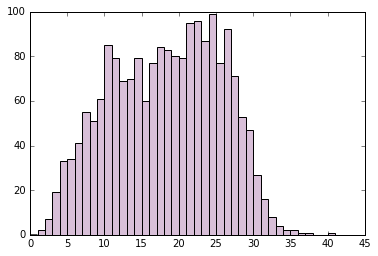


MAX SEQUENCE LENGTH: 41
Removing sentences that are greater than 41 tokens in length
Removed 0 data points
Removed 0 data points
Num training: 1639 	Num validation: 288


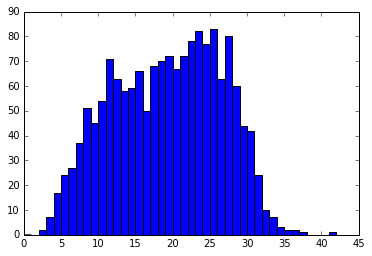

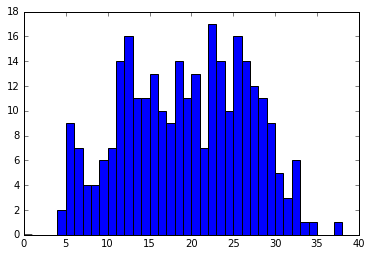

Did you check the vocabulary path?
Loaded vocabulary of size 13105
X train input shape (1639, 42, 13105)
X val input shape (288, 42, 13105)
y train input shape (1639,)
y val input shape (288,)


In [23]:
%run Data_preparation.ipynb

## Model

#### Definition

In [24]:
from keras.models import Model
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, Input, Concatenate

In [25]:
def build_model(hidden_dims, vocab_size, max_sequence_length, dropout=(0.1, 0.1)):
    
    model_input = Input(shape=(max_sequence_length, vocab_size))
    x = Dense(100, activation="linear")(model_input)
    
    x = Dropout(dropout[0])(x)
    conv_blocks = []
    
    filter_sizes = (3, 8)
    num_filters = 10
    
    for sz in filter_sizes:
        conv = Conv1D(filters=num_filters,
                             kernel_size=sz,
                             padding="valid",
                             activation="relu",
                             strides=1)(x)
        conv = MaxPool1D(pool_size=2)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    x = Dropout(dropout[1])(x)
    x = Dense(hidden_dims, activation="relu")(x)
    model_output = Dense(1, activation="sigmoid")(x)

    model = Model(model_input, model_output)
    
    return model

#### Train

In [26]:
def train(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=20, optimizer="adam", loss="binary_crossentropy", callbacks=None):
    # sparse inputs, adadelta or similar like RMSprop is preferred
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])
    
    # Define callbacks
    if callbacks is None:
        callback_list = []
    else: 
        callback_list = callbacks

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
          batch_size=batch_size, epochs=epochs,
          callbacks=callback_list)

    return history

#### Predict

In [27]:
def predict(models, x_test):
    """
    model can be a list of models or a single model. If it's a list then a list of N predictions will be returned,
    where N is the number of models
    """
    
    if type(models) != list:
        preds = np.where(models.predict(x_test) <= 0.5, 0, 1)
    
    else:
        preds = []
        for model in models:
            single_prediction = np.where(model.predict(x_test) <= 0.5, 0, 1)
            preds.append(single_prediction)

    return preds

In [28]:
# params
# Model Hyperparameters
dropout = (0.5, 0.8)
hidden_dims = 50

# Training parameters
batch_size = 32
epochs = 20

In [8]:
model = build_model(hidden_dims, vocab_size, MAX_SEQUENCE_LENGTH + 1, dropout)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 900)      0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 11, 100)      90100       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 11, 100)      0           dense_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 9, 10)        3010        dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [10]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.33, stratify=y_val, random_state=1)

In [11]:
list(map(np.shape, [x_val, x_test, y_val, y_test]))

[(305, 11, 900), (151, 11, 900), (305,), (151,)]

# Training

#### Callbacks

In [9]:
from keras import callbacks

In [10]:
# model_checkpoints = callbacks.ModelCheckpoint("k-fold-benchmark-checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=0)
early_stopping = callbacks.EarlyStopping(min_delta=0, patience=5, monitor="val_acc", mode="max")
model_checkpoints = callbacks.ModelCheckpoint("cnn-binary-classifier-{val_acc:.3f}.h5", monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=0)
callback_list = [early_stopping, model_checkpoints]

In [14]:
train(model, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)

Train on 4094 samples, validate on 305 samples
Epoch 1/20


InternalError: Blas GEMM launch failed : a.shape=(352, 900), b.shape=(900, 100), m=352, n=100, k=900
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/Reshape, dense_1/kernel/read)]]
	 [[Node: loss/mul/_127 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1070_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

# Cross validation

We define a cross validation function to be used if desired

In [29]:
from sklearn.model_selection import StratifiedKFold

In [30]:
def cross_val(x, y, hdims, vocab_size, max_sequence, dropout, folds=5, batch_size=32, epochs=50, callbacks=None):
    skf = StratifiedKFold(n_splits=folds)
    trained_models = []
    fold_counter = 0
    
    x, y = shuffle(x, y)
    
    for train_index, val_index in skf.split(x, y):
        # print("TRAIN:", train_index, "TEST:", val_index)
        print("Training for fold", fold_counter)
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = build_model(hdims, vocab_size, max_sequence, dropout)

        # Define callbacks
        if callbacks is None:
            callback_list = []
        else: 
            callback_list = callbacks
        
        train(model, x_train, y_train, x_val, y_val, batch_size, epochs, callbacks=callback_list)

        trained_models.append(model)
        fold_counter += 1
        return trained_models
        
    return trained_models

In [31]:
xcv = np.concatenate((x_train, x_val), axis=0) 
ycv = np.concatenate((y_train, y_val), axis=0)

In [32]:
xcv.shape, ycv.shape

((1927, 42, 13105), (1927,))

In [33]:
models = cross_val(xcv, ycv, hidden_dims, vocab_size, MAX_SEQUENCE_LENGTH + 1, dropout, callbacks=callback_list, epochs=30)

Training for fold 0
Train on 1541 samples, validate on 386 samples
Epoch 1/30
  96/1541 [>.............................] - ETA: 34s - loss: 0.6998 - acc: 0.4167

/homes/jl1809/.local/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132140). Check your callbacks.
  % delta_t_median)


1541/1541 [==============================] - 7s 5ms/step - loss: 0.6914 - acc: 0.5295 - val_loss: 0.6846 - val_acc: 0.5622
Epoch 2/30
1541/1541 [==============================] - 5s 3ms/step - loss: 0.6817 - acc: 0.5659 - val_loss: 0.6722 - val_acc: 0.5648
Epoch 3/30
1541/1541 [==============================] - 5s 3ms/step - loss: 0.6344 - acc: 0.6308 - val_loss: 0.5872 - val_acc: 0.7487
Epoch 4/30
1541/1541 [==============================] - 5s 3ms/step - loss: 0.4438 - acc: 0.7982 - val_loss: 0.3835 - val_acc: 0.8549
Epoch 5/30
1541/1541 [==============================] - 5s 3ms/step - loss: 0.1732 - acc: 0.9422 - val_loss: 0.1820 - val_acc: 0.9378
Epoch 6/30
1541/1541 [==============================] - 5s 3ms/step - loss: 0.0742 - acc: 0.9792 - val_loss: 0.2168 - val_acc: 0.9301
Epoch 7/30
1541/1541 [==============================] - 5s 3ms/step - loss: 0.0480 - acc: 0.9877 - val_loss: 0.1302 - val_acc: 0.9482
Epoch 8/30
1541/1541 [==============================] - 5s 3ms/step - los

# Test

In [15]:
y_preds = predict(model, x_test)

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(y_test, y_preds)

0.9933774834437086

In [21]:
x_test_2 = ["i am happy so angry <eos>",
            "today is a great day <eos>",            
            "that lady pisses me off <eos>",
            "fantastic , fantastic , fantastic <eos>",
            "why can not doctors just do their job properly ? <eos>",
            "i love m dada <eos>",
            "you look angry . <eos>",
            "we are all one big , happy family here . <eos>",
            "i was glad the movie had a happy ending . <eos>",
            "i am not happy with you . <eos>",
            "you are the best man <eos>",
            "i am so blessed <eos>",
            "i am happy happy <eos>",
            "i am happy <eos>",
            "very angry right now <eos>",
            "<user> lovely being home after spending some christmases overseas <laugh> <eos>",
            "<user> happy birthday keevie <eos>",
            "<user> happy new year girls las amo <happy> xx <eos>",
            "makes me so happy living my dream <eos>",
            "not been a good day at all ! <eos>",
            "<user> i hate this <curse> show ! hahaha <eos>",
            "sunflowers for in the . me . me to much happy"
         ]
          
x_test_2 = one_hot_data(x_test_2, word2id, MAX_SEQUENCE_LENGTH + 1)
y_test_2 = [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [41]:
x_test_pad = ["<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>"]
x_test_pad = one_hot_data(x_test_pad, word2id, MAX_SEQUENCE_LENGTH + 1)
y_test_pad = 0

In [42]:
# y_preds_2 = predict(model, x_val)
models[0].predict(x_test_pad)

array([[0.59125495]], dtype=float32)

In [20]:
y_preds_2.squeeze().tolist()

[1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,


In [27]:
y_test_2

[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [41]:
accuracy_score(y_val, y_preds_2)

0.980327868852459

### Cross val test

In [29]:
def get_best_model(models, x_test):
    best_model = 0
    best_score = 0

    preds = predict(models, x_test)
    
    for i, pred in enumerate(preds):
        acc = accuracy_score(y_test, pred)
        print("Model", i, "accuracy:", acc)
        if acc > best_score:
            best_model = models[i]
            best_score = acc
        
    return best_model, best_score

In [30]:
best_model, best_score = get_best_model(models, x_test)

Model 0 accuracy: 0.9536423841059603
Model 1 accuracy: 0.9801324503311258
Model 2 accuracy: 0.9867549668874173
Model 3 accuracy: 0.9735099337748344
Model 4 accuracy: 0.9668874172185431


In [31]:
best_score

0.9867549668874173

In [32]:
y_preds_2 = predict(best_model, x_test_2)

In [35]:
y_preds_2.squeeze().tolist()

[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]

In [36]:
y_test_2

[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [37]:
accuracy_score(y_test_2, y_preds_2)

0.8636363636363636

# Save

In [19]:
name = ("{0}/41_tokens/binclassifier-cnn-{1}drop-{2}hdim-{3:.3f}valacc").format(
    current_dir, dropout, hidden_dims, max(model.history.history['val_acc']))

model.save(name + ".h5")
# model.save_weights(name + "-weights.h5")